In [283]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import os
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.metrics.pairwise import rbf_kernel
# from sklearn.model_selection import GridSearchCV



In [488]:
def kernel(X,Y,method = 'rbf', degree=2, offset=0.5, sigma=1, beta=1.5):
    if method == 'rbf':
        return torch.exp(-sigma*torch.cdist(X,Y)*torch.cdist(X,Y))
    elif method == 'poly':
        return (X.T @ Y + offset)**degree
    elif method ==  'lap':
        N = Y.shape[1]
        d,n = X.shape 
        K = torch.zeros(n,N)
        for i in range(n):
            K[i,:] = torch.exp(-(abs(X[:,i].reshape(d,1)-Y)).sum(axis=0)*sigma)
            
        return K
    
    elif method == 'rat_quad':
        N = Y.shape[1]
        d,n = X.shape 
        K = torch.zeros(n,N)
        for i in range(n):
            K[i,:] = (((X[:,i].reshape(d,1)-Y)**2).sum(axis=0)+offset**2)**(-beta)     
        return K
    
    

In [479]:
N = 1000
sigma = 1
gamma = 1e-2
Lambda = 1e-6
degree=2

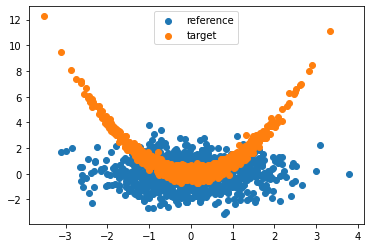

In [480]:
X = torch.randn(N,2)

xx = torch.randn(1, N)
zz = torch.randn(1, N)
# draw samples from target obtained by y = x^2 + z, x,z ~ N(0,1)
Y = torch.concat( (xx, torch.pow(xx, 2) + 0.3*zz), 1 ).reshape(2,N).T
# xt

# mean_x = X.mean()
# std_x = X.std()
# mean_y = Y.mean()
# std_y = Y.std()
# X = (X-mean_x)/std_x
# Y = (Y-mean_y)/std_y

plt.scatter(*X.T, label = 'reference')
plt.scatter(*Y.T, label = 'target')
plt.legend()

In [481]:
Z = torch.zeros(2,N,dtype=torch.float32,requires_grad=True)
# Z = torch.randn(2,N,dtype=torch.float32,requires_grad=True)

In [483]:


# K = polynomial_kernel(X, X, degree=2, gamma=gamma, coef0=0.5)
# K = torch.from_numpy(K)

K = kernel(X.T,X.T,method='poly',sigma=sigma,degree=degree ) # Take transpose

Kinv = torch.inverse(K + gamma*torch.eye(N))

In [484]:
def loss_fun(z):
    R = Lambda*((z[0:1,:]@Kinv@z[0:1,:].T)+(z[1:2,:]@Kinv@z[1:2,:].T))
    MMD = torch.sqrt((kernel(X+z.T,X+z.T,method='rbf',sigma=sigma,degree=degree) + kernel(Y,Y,method='rbf',sigma=sigma,degree=degree) - 2*kernel(X+z.T,Y,method='rbf',sigma=sigma,degree=degree)).sum())/N
    return MMD + R


In [485]:
lbfgs = torch.optim.LBFGS([Z],lr = 1,
                    history_size=10, 
                    max_iter=4, 
                    #tolerance_change = 1e-12, #1e-9
                    line_search_fn="strong_wolfe")

def closure():
    lbfgs.zero_grad()
    objective = loss_fun(Z)
    objective.backward()
    return objective

In [486]:
history_lbfgs = []
Error = 10
error = 1
i=0
while abs(Error - error) > 1e-12:
    l  =loss_fun(Z).item()
    Error = error
    error = l 
    print(i,l)
    history_lbfgs.append(l)
    lbfgs.step(closure)
    i += 1

0 0.0020000000949949026
1 0.0020000000949949026


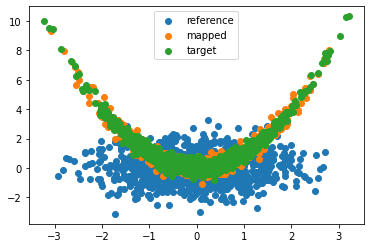

In [166]:
# Similar to code provided on Canvas

# plt.scatter(*X.T, label = 'reference')
# plt.scatter(*(((X + Z.T).T).detach().numpy()), label = 'mapped')
# plt.scatter(*Y.T, label = 'target')
# plt.legend()

In [461]:

# LOOK AT REPRESENTER THEOREM!!!!!!!

X_test = torch.randn(N,2)

xx = torch.randn(1, N)
zz = torch.randn(1, N)
# draw samples from target obtained by y = x^2 + z, x,z ~ N(0,1)
Y_test = torch.concat( (xx, torch.pow(xx, 2) + 0.3*zz), 1 ).reshape(2,N).T

K_test = kernel(X_test.T,X.T,method='poly',sigma=sigma,degree=degree)
# K_test = polynomial_kernel(X_test, X, degree=2, gamma=gamma, coef0=0.5)

with torch.no_grad():
    T1 = (K_test @ Kinv @ Z[0:1,:].T).T
    T2 = (K_test @ Kinv @ Z[1:2,:].T).T
    
print(X_test.size())
print(T1.size())

torch.Size([1000, 2])
torch.Size([1, 1000])


## Regularized Transport Problem:

$$T = \text{argmin}_{S:\mathbf{R}^d\rightarrow{R}^d} MMD_K (S(X),Y)+\lambda\sum_{j=1}^d ||S^j||_Q^2$$

where the kernels $K$ and $Q$ are not necessarily related. The job of $K$ is to distinguish $S(X)$ and $Y$, whereas $Q$ regularizes $S$. 

### Representer Theorem for the Above:

$$T(x)=(T^1(x),\dots,T^d(x))^T$$
$$T^j = Q(\cdot,X)Q(X,X)^{-1}(Z_{ij})^T$$


where $Z\in\mathbf{R}^{n\times d}$ solves
$$\text{min}_Z \text{MMD}_K (Z,Y)+\lambda\sum_{j=1}^d Z_{ij}Q(X,X)^{-1}(Z_{ij})^T$$

We want to represent the minimization in this form (summation), not the way done in code.

torch.Size([1, 1000])


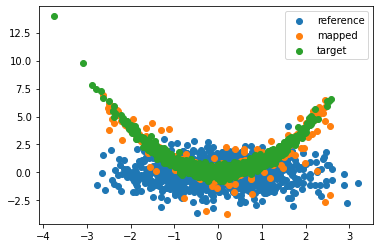

In [462]:
# See the representer theorem. 



xx = T1+X_test[:,0].T # Add T1 to the x values of the reference points (blue)
# xx = xx*std_x + mean_x

yy = T2+X_test[:,1].T # Add t2 to the y values of the reference points (blue)
print(yy.size())
# yy = yy*std_y + mean_y

plt.scatter(*X_test.T, label = 'reference')
plt.scatter(xx, yy, label = 'mapped')
plt.scatter(*Y_test.T, label = 'target')
plt.legend()

# Spiral Data

# Works well with Rbf Rbf combo
# Reference data should be circle for best performace

# TEST DIFFERENT SIGMA VALUES FOR RBF
# Lplacian as Q kernel and RBF as mmd works better

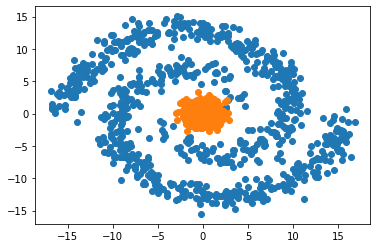

In [503]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt

N = 400
sigma = 0.5
gamma = 1e-2
Lambda = 1e-6
degree=2


theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)



# X = x_a.copy()
# np.random.shuffle(X[:,1])
# X = (torch.from_numpy(X)).type(torch.FloatTensor)

#THIS ONE
###################
# X = torch.randn(N,2) 
#X[:,0] = X[:,0]*5

# Y = (torch.from_numpy(x_a)).type(torch.FloatTensor)
###################

X = torch.randn(2*N,2)


Y = (torch.from_numpy(np.concatenate((x_a,x_b)))).type(torch.FloatTensor)


plt.scatter(Y[:,0],Y[:,1])
plt.scatter(X[:,0],X[:,1])
plt.show()


In [504]:
N = 800
Z = torch.zeros(2,N,dtype=torch.float32,requires_grad=True)

# kernels = ['rbf','poly',]

# for 


In [506]:
N = 800

Z = torch.zeros(2,N,dtype=torch.float32,requires_grad=True)
K = kernel(X.T,X.T,method='lap',sigma=sigma,degree=degree ) # Take transpose

Kinv = torch.inverse(K + gamma*torch.eye(N))


In [507]:
def loss_fun(z):
    R = Lambda*((z[0:1,:]@Kinv@z[0:1,:].T)+(z[1:2,:]@Kinv@z[1:2,:].T))
    MMD = torch.sqrt((kernel(X+z.T,X+z.T,method='rbf',sigma=sigma,degree=degree) + kernel(Y,Y,method='rbf',sigma=sigma,degree=degree) - 2*kernel(X+z.T,Y,method='rbf',sigma=sigma,degree=degree)).sum())/N
    return MMD + R

lbfgs = torch.optim.LBFGS([Z],lr = 1,
                    history_size=10, 
                    max_iter=4, 
                    #tolerance_change = 1e-12, #1e-9
                    line_search_fn="strong_wolfe")

def closure():
    lbfgs.zero_grad()
    objective = loss_fun(Z)
    objective.backward()
    return objective


In [508]:
history_lbfgs = []
Error = 10
error = 1
i=0
while abs(Error - error) > 1e-12:
    l  =loss_fun(Z).item()
    Error = error
    error = l 
    print(i,l)
    history_lbfgs.append(l)
    lbfgs.step(closure)
    i += 1

0 0.5993071794509888
1 0.5392515659332275
2 0.14010904729366302
3 0.07518982887268066
4 0.05728888511657715
5 0.04317737743258476
6 0.035554394125938416
7 0.031498078256845474
8 0.027308933436870575
9 0.024158582091331482
10 0.021466873586177826
11 0.01956111378967762
12 0.018054289743304253
13 0.016898538917303085
14 0.015949655324220657
15 0.015182830393314362
16 0.014651317149400711
17 0.013994434848427773
18 0.01338188722729683
19 0.012998377904295921
20 0.012745898216962814
21 0.012411089614033699
22 0.012274065986275673
23 0.01201273687183857
24 0.011839156970381737
25 0.011720347218215466
26 0.01164580974727869
27 0.011586299166083336
28 0.011515600606799126
29 0.011415413580834866
30 0.0112033411860466
31 0.011148621328175068
32 0.011105754412710667
33 0.01102119218558073
34 0.010824574157595634
35 0.010756317526102066
36 0.01073266938328743
37 0.010716096498072147
38 0.010692890733480453
39 0.010669199749827385
40 0.010652648285031319
41 0.010637110099196434
42 0.0106203518807

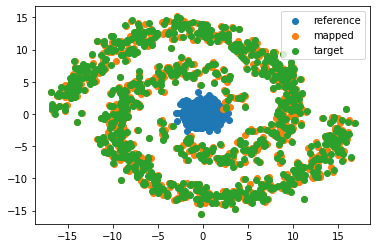

In [509]:
# Similar to code provided on Canvas

plt.scatter(*X.T, label = 'reference')
plt.scatter(*(((X + Z.T).T).detach().numpy()), label = 'mapped')
plt.scatter(*Y.T, label = 'target')
plt.legend()

torch.Size([800, 2])
torch.Size([1, 800])
torch.Size([1, 800])


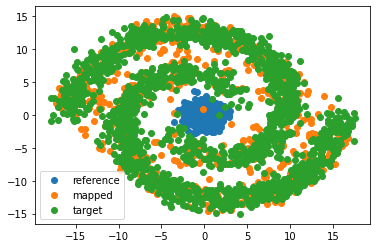

In [513]:
N = 800
sigma = 0.5
gamma = 1e-2
Lambda = 1e-6
degree=2


theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

X_test = torch.randn(N,2) 
Y_test = (torch.from_numpy(np.concatenate((x_a,x_b)))).type(torch.FloatTensor)

K_test = kernel(X_test.T,X.T,method='lap',sigma=sigma,degree=degree)
# K_test = polynomial_kernel(X_test, X, degree=2, gamma=gamma, coef0=0.5)

with torch.no_grad():
    T1 = (K_test @ Kinv @ Z[0:1,:].T).T
    T2 = (K_test @ Kinv @ Z[1:2,:].T).T
    
print(X_test.size())
print(T1.size())

xx = T1+X_test[:,0].T # Add T1 to the x values of the reference points (blue)
# xx = xx*std_x + mean_x

yy = T2+X_test[:,1].T # Add t2 to the y values of the reference points (blue)
print(yy.size())
# yy = yy*std_y + mean_y

plt.scatter(*X_test.T, label = 'reference')
plt.scatter(xx, yy, label = 'mapped')
plt.scatter(*Y_test.T, label = 'target')
plt.legend()